# GRU的Pytorch API使用以及手动实现GRU Forward函数
- GRU Forward公式：
    - 从公式可以看出，单层GRU网络的参数约等于单层LSTM参数的0.75倍
    - ![CleanShot 2024-08-01 at 17.22.05@2x.png](<attachment:CleanShot 2024-08-01 at 17.22.05@2x.png>)
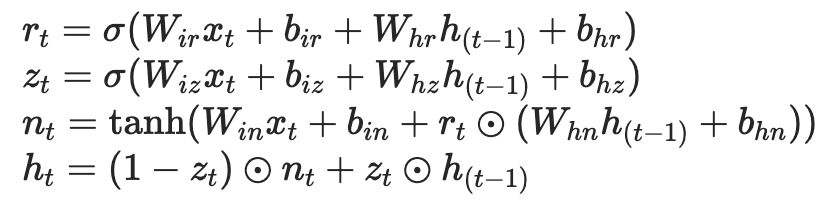

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

bs, T, i_size, h_size = 2, 3, 4, 5  # 批大小, 输入序列长度, 输入特征长度, 输出特征长度
input = torch.randn(bs, T, i_size)  # 随机初始化一个特征序列
h0 = torch.zeros(bs, h_size)  # 初始隐含状态

In [2]:
# GRU Forward的动手实现
def gru_forward(input, initial_state, w_ih, w_hh, b_ih, b_hh):
    prev_h = initial_state
    bs, T, i_size = input.shape
    h_size = w_ih.shape[0] // 3

    output = torch.zeros(bs, T, h_size)  # 输出  如果是动手实现GRU类  这个应该放在类初始化中初始化为属性
    
    for t in range(T):
        x = input[:, t, :]
        w_times_x = x @ w_ih.T           # [bs, 3*h_size]
        w_times_h = prev_h @ w_hh.T      # [bs, 3* h_size]

        # 重置门r_t
        r_t = torch.sigmoid(w_times_x[:, :h_size] + w_times_h[:, :h_size] + b_ih[:h_size] + b_hh[:h_size])
        # 更新门
        z_t = torch.sigmoid(w_times_x[:, h_size:2*h_size] + w_times_h[:, h_size:2*h_size] + \
                                                            b_ih[h_size:2*h_size] + b_hh[h_size:2*h_size])
        # 候选状态
        n_t = torch.tanh(w_times_x[:,2*h_size:3*h_size] + b_ih[2*h_size:3*h_size] + \
                                                            r_t * (w_times_h[:, 2*h_size:3*h_size] + b_hh[2*h_size:3*h_size]))
        prev_h = (1 - z_t) * n_t + z_t * prev_h

        output[:, t, :] = prev_h
    
    return output, prev_h

        

In [3]:
# Pytorch API
gru_layer = nn.GRU(i_size, h_size, batch_first = True)
output, h_final = gru_layer(input, h0.unsqueeze(0))


for k, v in gru_layer.named_parameters():
    print(k, v.shape)

weight_ih_l0 torch.Size([15, 4])
weight_hh_l0 torch.Size([15, 5])
bias_ih_l0 torch.Size([15])
bias_hh_l0 torch.Size([15])


In [4]:
output_custom, h_final_custom  = gru_forward(input, h0, gru_layer.weight_ih_l0, gru_layer.weight_hh_l0, gru_layer.bias_ih_l0, gru_layer.bias_hh_l0)

print(torch.allclose(output, output_custom))
print(torch.allclose(h_final, h_final_custom))

True
True
